In [1]:
from scipy.io import loadmat
import scipy
import numpy as np
import glob

import matplotlib.pyplot as plt
import sys
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from firingrate import rolling_window

To run preprocessing script:

ml load matlab

matlab -nodesktop -nosoftwareopengl -nosplash -nodisplay -r "run('preprocess_data.m'); exit"

TODO:
- load in targetPos data
- try to find trials where monkey is actively paying attention
- find OL/CL trial labels

In [148]:
data_folder = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/monkey/JenkinsC/'

files = glob.glob(data_folder + '*mat')

In [193]:
loadmat(files[0])['miniR'][0][0].dtype.names

('cursorPos',
 'spikeRaster',
 'spikeRaster2',
 'trialNum',
 'isSuccessful',
 'startTrialParams')

In [228]:
class MonkeyDataStruct(object):
    """
    Generates a simplified R struct from NHP cursor data.
    """
    def __init__(self, file, causal_filter = 0, bin_size = 20, verbose = False):
        
        assert isinstance(file, str), "<file> must be a string"
        
        dat    = loadmat(files[0])['miniR'][0][0]
        fields = list(dat.dtype.names)
        
        if verbose:
            print('Found fields: ', fields)
            
        self.file     = file
        self.date     = file.split('R_')[1].split('.mat')[0]
        self.bin_size = bin_size
        
        
        self.TX  = list()
        self.TX2 = list()
        self.cursorPos    = list()
        self.targetPos    = list()
        self.IsSuccessful = list()
        self.trialNum     = list()
        self.trialType    = list()
        self.decodeOn     = list()

        for i, field in enumerate(fields):
            monkey_dict[field] = list()
            for j in range(dat[i].shape[-1]):

                trl_dat = dat[i][0, j].T
                if scipy.sparse.issparse(trl_dat):
                    trl_dat = trl_dat.toarray()

                if field in ['spikeRaster', 'spikeRaster2']:
                    trl_dat = rolling_window(trl_dat, window_size = self.bin_size, padding = 0)[::self.bin_size, :, :].mean(axis = 1)
                    
                    if field == 'spikeRaster':
                        self.TX.append(trl_dat)
                    else:
                        self.TX2.append(trl_dat)

                elif field == 'cursorPos':
                    trl_dat = trl_dat[::self.bin_size, :2]
                    self.cursorPos.append(trl_dat)
                    
                elif field == 'isSuccessful':
                    self.IsSuccessful.append(trl_dat)
                
                elif field == 'trialNum':
                    self.trialNum.append(trl_dat)

                elif field == 'startTrialParams':
                    trl_params = trl_dat[0][0]

                    trialparam_fields = trl_params.dtype.names

                    for j, param_field in enumerate(trialparam_fields):
                        
                        if param_field == 'taskID':
                            self.trialType.append(trl_params[j])
                        
                        elif param_field == 'posTarget':
                            self.targetPos.append(trl_params[j][:2])

                        elif param_field == 'decodeOn':
                            self.decodeOn.append(trl_params[j][0])

            
            if verbose:
                print(field, 'done')
        
        '''
        #####################################

        self.blockList            = dat[0][0]    # contains block labels 
        self.gameName             = dat[18]   # of same length as blocklist: contains string label of task for each block
        self.cursorPos_continuous = dat[6].astype('float')
        self.targetPos_continuous = dat[7].astype('float')
        self.decClick_continuous  = np.concatenate(dat[11])
        self.onTarget_continuous  = np.concatenate(dat[8])
        self.TX_continuous        = dat[12].astype('float')
        self.TX_thresh            = dat[13]
        self.trialEpochs          = dat[15] - 1  # account for MATLAB's 1-indexing
        self.trialEpochs[:, 1]   += 1            # account for MATLAB's inclusive indexing 
        self.interTrialPeriods    = dat[17][~np.isnan(dat[17]).any(axis = 1), :].astype(int) - 1
        self.sysClock             = dat[4]
        self.nspClocks            = dat[5]
        self.decVel               = dat[10]
        self.n_trials             = self.trialEpochs.shape[0]
        self.n_channels           = self.TX_continuous.shape[1] 
         
        # now load in neural data and smooth if requested:
        if causal_filter > 0:
            self.TX_continuous = firingrate.gaussian_filter1d(self.TX_continuous, sigma = causal_filter, axis = 0, causal = True)
        
        # correct the flipped pedestal cable day
        if self.date in ['2017.08.04']: # add if any more such days found
            self.TX_continuous = self.TX_continuous[:, np.concatenate([np.arange(96, 192), np.arange(0, 96)])]

        TX         = list()
        blockNums  = list()
        trialType  = list()
        isSuccessful = list()

        targetSize, cursorSize = list(), list()
        cursorPos, targetPos   = list(), list()
        decClick               = list()
        onTarget               = list()
        
        keep = list()
        for i in range(self.n_trials):
            start, stop = self.trialEpochs[i, :] 
            if stop - start > 5:         # toss out weird short trials
                keep.append(i)

                targetSize.append(dat[1][start][0])
                cursorSize.append(dat[2][start][0])
                blockNums.append(dat[3][start][0])

                trialType.append(self.gameName[np.where(self.blockList == blockNums[-1])[0]][0][0][0])
                isSuccessful.append(dat[19][i][0])

                TX.append(deepcopy(self.TX_continuous[start:stop, :]))
                cursorPos.append(deepcopy(self.cursorPos_continuous[start:stop, :]))
                targetPos.append(deepcopy(self.targetPos_continuous[start:stop, :]))
                decClick.append(deepcopy(self.decClick_continuous[start:stop]))
                onTarget.append(deepcopy(self.onTarget_continuous[start:stop]))

        self.TX           = TX
        self.targetSize   = np.asarray(targetSize, dtype = 'object')
        self.cursorSize   = np.asarray(cursorSize, dtype = 'object')
        self.targetPos    = targetPos
        self.cursorPos    = cursorPos
        self.decClick     = np.asarray(decClick, dtype = 'object')
        self.onTarget     = np.asarray(onTarget, dtype = 'object')
        self.blockNums    = np.asarray(blockNums, dtype = 'object')
        self.IsSuccessful = np.asarray(isSuccessful, dtype = 'object')
        self.trialType    = np.asarray(trialType, dtype = 'object')
        
        self.trialEpochs  = self.trialEpochs[np.asarray(keep), :]
                           
        
        # align screen coordinates across tasks
        self.screenAligned = False
        if alignScreens:
            self.alignTaskScreens()
            self.screenAligned = True
            
        '''
    

In [229]:
dat = MonkeyDataStruct(files[0], verbose = True)

Found fields:  ['cursorPos', 'spikeRaster', 'spikeRaster2', 'trialNum', 'isSuccessful', 'startTrialParams']
cursorPos done
spikeRaster done
spikeRaster2 done
trialNum done
isSuccessful done
startTrialParams done


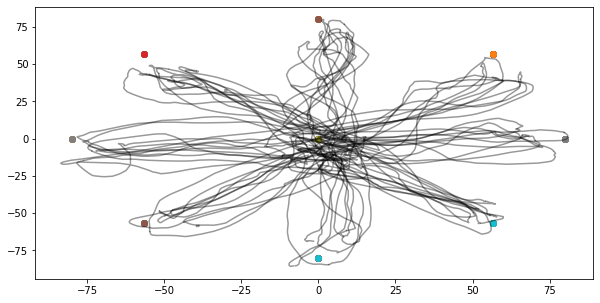

In [224]:
for idx in range(1300, 1400):
    plt.plot(dat.cursorPos[idx][:, 0], dat.cursorPos[idx][:, 1], c = 'k', alpha = 0.4)
    plt.scatter(*dat.targetPos[idx])
    
plt.show()

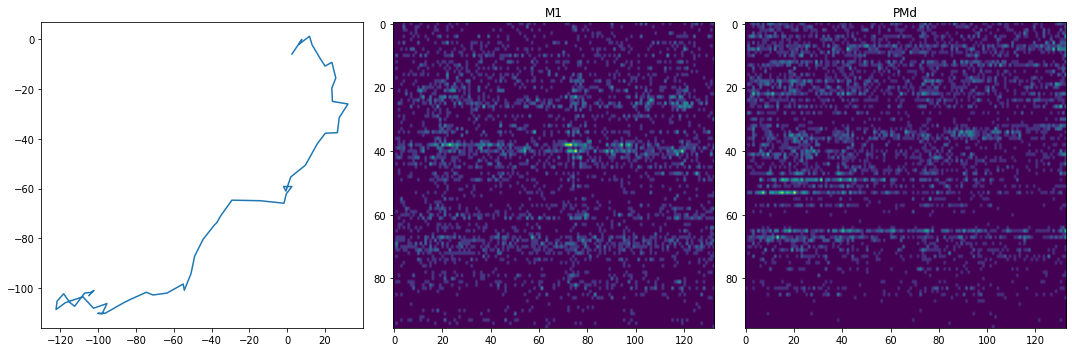

In [236]:
from sklearn.linear_model import LinearRegression

figSize(5, 15)

trl = 1054

plt.subplot(1, 3, 1)
plt.plot(dat.cursorPos[trl][:, 0], dat.cursorPos[trl][:, 1])

plt.subplot(1, 3, 2)
plt.imshow(dat.TX[trl].T, aspect = 'auto')
plt.title('M1')

plt.subplot(1, 3, 3)
plt.imshow(dat.TX2[trl].T, aspect = 'auto')
plt.title('PMd')

plt.tight_layout()
plt.show()

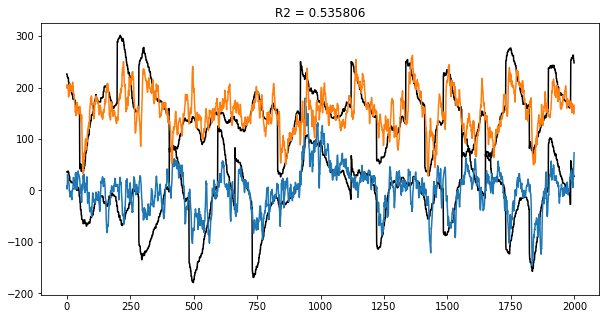

In [280]:
from firingrate import gaussian_filter1d

smoothed = gaussian_filter1d(np.concatenate(dat.TX), sigma = 4, axis = 0, causal= True)
vel      = np.diff(np.concatenate(dat.cursorPos), axis = 0)
vel      = np.concatenate([x.T - y for x, y in zip(dat.targetPos, dat.cursorPos)])


timerange = np.arange(160000, 200000) # example time range when engaged in task

lm    = LinearRegression().fit(smoothed[timerange], vel[timerange])
r2    = lm.score(smoothed[timerange], vel[timerange])
preds = lm.predict(smoothed[timerange])

figSize(5, 10)

plt.plot(vel[timerange][:2000] + [0, 150], c = 'k')
plt.plot(preds[:2000] + [0, 150])
plt.title('R2 = {:f}'.format(r2))

plt.show()

In [274]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 3).fit(smoothed)
smoothed = pca.transform(smoothed)

Component 0: 0.5449789185881323
Component 1: 0.04486381744317388
Component 2: 0.03268205147356517


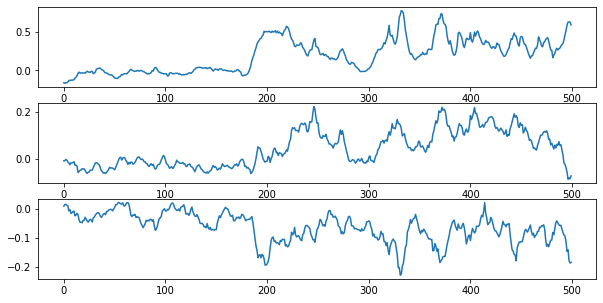

In [275]:

for i in range(pca.n_components):
    print(f'Component {i}:', pca.explained_variance_ratio_[i])
    
    plt.subplot(3, 1, i + 1)
    plt.plot(smoothed[:500, i])

plt.show()
    

In [276]:

def getDirectionVectors(pca, lm):
    
    direction_vectors  = pca.components_[1:, :].dot(lm.coef_.T)
    direction_vectors /= np.linalg.norm(direction_vectors, axis = 0)
    
    return direction_vectors

/home/users/ghwilson/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/users/ghwilson/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


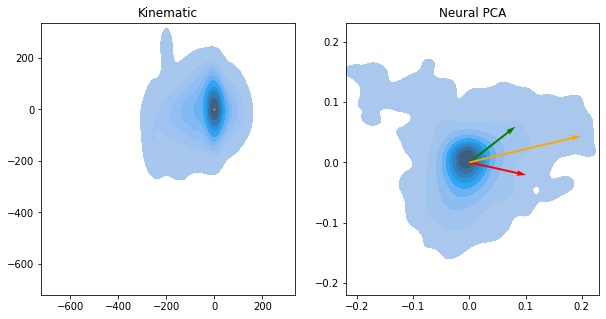

In [277]:
import seaborn as sns
import scipy 

figSize(5, 10)


labels = ['Kinematic', 'Neural PCA']

for i, datas in enumerate([vel, smoothed[:, 1:]]):
    plt.subplot(1, 2, i + 1)
    
    sns.kdeplot(datas[::100, 0], datas[::100, 1], fill = True)
    lims = [np.percentile(datas, 1) - np.std(datas), np.percentile(datas, 99) + np.std(datas)]
    plt.xlim(lims)
    plt.ylim(lims)

    if i == 1:
        vectors = getDirectionVectors(pca, lm) / 10
        plt.quiver([0, 0], [0, 0], vectors[0, :], vectors[1, :],
                   color = ['r', 'g'], units = 'xy', scale = 1)

    skew    = scipy.stats.skew(datas, axis = 0)
    plt.quiver(0, 0, *skew, color = 'orange', units = 'xy', scale = 1)
    
    plt.title(labels[i])

plt.show()